In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
def norm(data):
    return (data)/(max(data))

In [44]:
appa1 = pd.read_csv("appa1_gt.csv")

In [45]:
appa1 = pd.read_csv("data/appa1.csv")

# Data

| ts        | The time the data was taken (date time)                                                                      |
|-----------|--------------------------------------------------------------------------------------------------------------|
| Rs1 - Rs8 | Resistance value of all 8 sensors, usually paired the same way (1,2) (3,4)...                                |
| Rh1 - Rh8 | Resistance value of the heaters, ideally should stay stable or correlated to tempurature                     |
| Vh1 - Vh8 | Voltage of the heater                                                                                        |
| T         | Temperature in C                                                                                             |
| RH        | Relative Humidity                                                                                            |
| P         | Air pressure                                                                                                 |
| BME       | Volatile Organic Compounds (VOC), from the BME280 sensor. Likely unrelated but added because its extra data! |

In [46]:
appa1.columns
appa1 = appa1.drop(columns='Unnamed: 0')

In [47]:
appa1.at[381849, "Time"] = pd.to_datetime("Tue Jan 12 2021 15:39:26 GMT+0000") + pd.to_timedelta(1, unit="min")

In [48]:
appa1

,ts,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,T,RH,P,BME,Time
0,Mon Aug 26 2019 17:15:38 GMT+0100 (British Sum...,81512.0,1952.0,119156360.0,85111688.0,499000000.0,499000000.0,499000000.0,499000000.0,90.7,...,0.35,0.35,0.35,0.35,0.35,25.0,62.9,979.4,87.91,NaN
1,Mon Aug 26 2019 17:16:39 GMT+0100 (British Sum...,80610.0,1950.0,117028568.0,86231576.0,499000000.0,499000000.0,499000000.0,499000000.0,81.0,...,0.35,0.35,0.35,0.35,0.35,25.3,62.5,979.3,108.96,NaN
2,Mon Aug 26 2019 17:17:39 GMT+0100 (British Sum...,80412.0,1957.0,117028568.0,85111688.0,499000000.0,499000000.0,499000000.0,499000000.0,81.9,...,0.36,0.36,0.35,0.36,0.35,25.5,62.0,979.3,125.47,NaN
3,Mon Aug 26 2019 17:18:40 GMT+0100 (British Sum...,80117.0,1961.0,118082880.0,87381328.0,499000000.0,499000000.0,499000000.0,499000000.0,82.4,...,0.36,0.35,0.35,0.36,0.35,25.8,61.6,979.3,139.41,NaN
4,Mon Aug 26 2019 17:19:41 GMT+0100 (British Sum...,79873.0,1965.0,118082880.0,87381328.0,499000000.0,499000000.0,499000000.0,499000000.0,80.1,...,0.35,0.35,0.35,0.35,0.35,26.0,61.2,979.3,150.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183837,Mon Jul 25 2022 13:57:59 GMT+0100 (British Sum...,11636364.0,744186.0,32080200.0,209836064.0,499000000.0,499000000.0,31674768.0,278910496.0,500.0,...,2.57,3.89,4.03,3.95,4.33,41.5,19.5,985.5,5467.63,NaN
1183838,Mon Jul 25 2022 13:58:59 GMT+0100 (British Sum...,11636364.0,739884.0,32820512.0,224561408.0,499000000.0,499000000.0,32361174.0,282204736.0,500.0,...,2.57,3.90,4.03,3.95,4.34,41.6,19.1,985.5,5501.55,NaN
1183839,Mon Jul 25 2022 13:59:59 GMT+0100 (British Sum...,11636364.0,748538.0,32653062.0,220689648.0,499000000.0,499000000.0,32042914.0,285577696.0,500.0,...,2.57,3.89,4.03,3.95,4.33,41.7,19.4,985.5,5490.20,NaN
1183840,Mon Jul 25 2022 14:00:59 GMT+0100 (British Sum...,11636364.0,752941.0,32405064.0,213333328.0,499000000.0,499000000.0,31843626.0,287871488.0,500.0,...,2.57,3.89,4.02,3.95,4.33,41.8,20.0,985.6,5507.25,NaN


In [49]:
appa1 = appa1.rename(columns = {"ts": "Time", "T": "Temperature", "RH": "Relative_Humidity", "P": "Pressure", "T": "Temperature", "T": "Temperature", "BME": "VOC"})

# interpolate NaN values
for i, row in tqdm(appa1.iterrows(), total=len(appa1)):
    if type(row.Time) != str:
        print(i, appa1.iloc[i-1].Time, appa1.iloc[i].Time)
        appa1.at[i, "Time"] = pd.to_datetime(" ".join(appa1.iloc[i-1].Time.split(" ")[:6])) + pd.to_timedelta(1, unit="m")

  0%|          | 0/1183842 [00:02<?, ?it/s]

0 Time    Mon Jul 25 2022 14:02:00 GMT+0100 (British Sum...
Time                                                  NaT
Name: 1183841, dtype: object Time    Mon Aug 26 2019 17:15:38 GMT+0100 (British Sum...
Time                                                  NaT
Name: 0, dtype: object


AttributeError: 'Series' object has no attribute 'split'

In [ ]:
appa1.Time = pd.to_datetime(appa1.Time.map(lambda x:  " ".join(x.split(" ")[:6]) if type(x) == str else x), utc=True)

In [ ]:
appa1_time = appa1.set_index("Time")

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(appa1_time.Rs1)
plt.xticks(rotation=45)
plt.show()

NameError: name 'appa1_time' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
#appa1.columns
appa1_hr = pd.DataFrame(columns = ['Time', 'Rs1', 'Rs2', 'Rs3', 'Rs4', 'Rs5', 'Rs6', 'Rs7', 'Rs8', 'Rh1',
       'Rh2', 'Rh3', 'Rh4', 'Rh5', 'Rh6', 'Rh7', 'Rh8', 'Vh1', 'Vh2', 'Vh3',
       'Vh4', 'Vh5', 'Vh6', 'Vh7', 'Vh8', 'Temperature', 'Relative_Humidity',
       'Pressure', 'VOC'])

for i in tqdm(range(0, len(appa1)-60, 60), total=int(len(appa1)-60)/60):
       row = appa1.iloc[i:i+60].mean(axis=0)
       temp = [appa1.iloc[i].Time]
       temp[1:] = row
       appa1_hr.loc[len(appa1_hr.index)] = temp
       

NameError: name 'appa1' is not defined

In [ ]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh3,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
0,2019-08-26 18:15:38+00:00,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.353333,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667
1,2019-08-27 16:01:41+00:00,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.354333,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167
2,2019-08-27 17:02:33+00:00,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.307833,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167
3,2019-08-27 18:03:26+00:00,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.309667,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333
4,2019-08-27 19:04:19+00:00,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.309500,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.389667,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333
19726,2022-07-25 10:20:24+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.389667,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667
19727,2022-07-25 11:20:31+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.390000,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167
19728,2022-07-25 12:20:39+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.389500,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833


In [53]:
appa1_hr.to_csv("exports/appa1_hr.csv")
appa1_gt = pd.read_csv("exports/appa1_gt_clean_withCO.csv")
appa1_marco = pd.read_csv("appa1_gt.csv")
appa1_hr['time'] = appa1_marco['Time']
#appa1_hr.time = pd.to_datetime(appa1_hr.time)
#appa1_hr.time = appa1_hr.time.dt.tz_localize(None)
appa1_hr.head()

NameError: name 'appa1_hr' is not defined

In [ ]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC,time
0,2019-08-26 18:15:38+00:00,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667,2020-07-31 01:00:00
1,2019-08-27 16:01:41+00:00,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167,2020-07-31 02:00:00
2,2019-08-27 17:02:33+00:00,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167,2020-07-31 03:00:00
3,2019-08-27 18:03:26+00:00,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333,2020-07-31 04:00:00
4,2019-08-27 19:04:19+00:00,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000,2020-07-31 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333,NaT
19726,2022-07-25 10:20:24+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667,NaT
19727,2022-07-25 11:20:31+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167,NaT
19728,2022-07-25 12:20:39+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833,NaT


In [ ]:
for i, row in tqdm(appa1_hr.iterrows(), total = len(appa1_hr)):
    appa1_hr.at[i, "time"] = row.Time.replace(microsecond=0, second=0, minute=0)
#appa1_hr.Time = appa1_hr.Time.dt.round('60min')

100%|██████████| 19730/19730 [00:00<00:00, 25288.23it/s]


In [ ]:
appa1_hr = appa1_hr.rename(columns = {"Time": "time", "time":"Time"})


In [ ]:
appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
appa1_hr.Time = appa1_hr.Time.dt.tz_localize(None)
appa1_hr

,time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC,Time
0,2019-08-26 18:15:38,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667,2019-08-26 18:00:00
1,2019-08-27 16:01:41,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167,2019-08-27 16:00:00
2,2019-08-27 17:02:33,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167,2019-08-27 17:00:00
3,2019-08-27 18:03:26,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333,2019-08-27 18:00:00
4,2019-08-27 19:04:19,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000,2019-08-27 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333,2022-07-25 09:00:00
19726,2022-07-25 10:20:24,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667,2022-07-25 10:00:00
19727,2022-07-25 11:20:31,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167,2022-07-25 11:00:00
19728,2022-07-25 12:20:39,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833,2022-07-25 12:00:00


In [50]:
appa1_gt.Time = pd.to_datetime(appa1_gt.Time)
appa1_gt

NameError: name 'appa1_gt' is not defined

In [51]:
appa1_hr.merge(appa1_gt, how='left', on="Time")

NameError: name 'appa1_hr' is not defined

In [52]:
appa1_hr.iloc[380]

NameError: name 'appa1_hr' is not defined

In [200]:
#6380
#3937
#17641
appa1_hr = appa1_hr.iloc[6380:]
print(len(appa1_hr))

13350


In [251]:
appa1_gt = appa1_gt.iloc[3864:17569]
print(len(appa1_gt))

13705


In [ ]:
for i, row in appa1.iterrows():


In [176]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh3,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
19140,2022-06-30 22:00:00+00:00,1.520432e+06,1.564351e+06,1.561125e+07,6.325280e+07,3.226983e+08,499000000.0,4.529892e+07,3.069251e+08,99.243333,...,2.382667,2.520833,3.891333,3.897167,3.820000,4.260167,35.351667,34.003333,987.981667,970.696667
19141,2022-06-30 23:00:00+00:00,1.575852e+06,1.497123e+06,1.603984e+07,6.686113e+07,3.391781e+08,499000000.0,4.493697e+07,3.116132e+08,99.291667,...,2.382500,2.521000,3.891500,3.897167,3.819833,4.260000,34.823333,34.250000,988.283333,981.544833
19142,2022-07-01 00:00:00+00:00,1.596473e+06,1.422728e+06,1.690417e+07,6.886274e+07,3.706232e+08,499000000.0,4.437409e+07,3.207355e+08,99.200000,...,2.381833,2.521000,3.891333,3.898167,3.820333,4.260833,34.650000,33.860000,988.831667,1019.689167
19143,2022-07-01 01:00:00+00:00,1.594714e+06,1.355145e+06,1.677791e+07,6.840802e+07,3.709504e+08,499000000.0,4.257829e+07,3.318025e+08,99.315000,...,2.382500,2.520667,3.892333,3.897000,3.819833,4.260000,35.440000,32.421667,988.831667,1091.850167
19144,2022-07-01 02:00:00+00:00,1.452168e+06,1.388080e+06,1.518150e+07,6.170452e+07,3.263237e+08,499000000.0,4.487997e+07,3.139016e+08,99.286667,...,2.382333,2.520833,3.891833,3.897167,3.820000,4.260167,35.751667,32.331667,989.258333,1061.159167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:00:00+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,499000000.0,3.847504e+07,3.285689e+08,500.000000,...,2.389667,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333
19726,2022-07-25 10:00:00+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,499000000.0,3.158873e+07,3.526001e+08,500.000000,...,2.389667,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667
19727,2022-07-25 11:00:00+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,499000000.0,2.667558e+07,3.659995e+08,500.000000,...,2.390000,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167
19728,2022-07-25 12:00:00+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,499000000.0,2.301014e+07,3.719886e+08,500.000000,...,2.389500,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833


In [360]:
appa1_fourth

,Time,Rs5,Rs6,Rs1,Rs2,Rs3,Rs4,Rs7,Rs8,Rh5,...,Vh1,Vh2,Vh3,Vh4,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
907238,2022-01-14 00:00:32+00:00,3477586.0,8094862.0,12800000.0,21333334.0,4904214.0,4806609.0,499000000.0,109770288.0,112.7,...,2.92,2.95,2.28,2.32,0.38,4.18,41.0,4.5,991.6,3604.34
907239,2022-01-14 00:01:32+00:00,3494880.0,8113186.0,12800000.0,21333334.0,4911742.0,4817464.0,499000000.0,109938648.0,112.7,...,2.93,2.95,2.28,2.32,0.38,4.18,41.0,4.5,991.6,3604.34
907240,2022-01-14 00:02:32+00:00,3493518.0,8120540.0,12800000.0,21333334.0,4923077.0,4815651.0,499000000.0,107305392.0,112.7,...,2.92,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
907241,2022-01-14 00:03:32+00:00,3502223.0,8136209.0,12800000.0,21333334.0,4926867.0,4822909.0,499000000.0,110107528.0,112.7,...,2.93,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
907242,2022-01-14 00:04:32+00:00,3501197.0,8138980.0,12800000.0,21333334.0,4936367.0,4828366.0,499000000.0,110959752.0,112.7,...,2.93,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183837,2022-07-25 14:57:59+00:00,499000000.0,499000000.0,11636364.0,744186.0,32080200.0,209836064.0,31674768.0,278910496.0,128.5,...,3.91,3.65,2.39,2.57,3.95,4.33,41.5,19.5,985.5,5467.63
1183838,2022-07-25 14:58:59+00:00,499000000.0,499000000.0,11636364.0,739884.0,32820512.0,224561408.0,32361174.0,282204736.0,128.6,...,3.91,3.64,2.39,2.57,3.95,4.34,41.6,19.1,985.5,5501.55
1183839,2022-07-25 14:59:59+00:00,499000000.0,499000000.0,11636364.0,748538.0,32653062.0,220689648.0,32042914.0,285577696.0,128.5,...,3.91,3.64,2.39,2.57,3.95,4.33,41.7,19.4,985.5,5490.20
1183840,2022-07-25 15:00:59+00:00,499000000.0,499000000.0,11636364.0,752941.0,32405064.0,213333328.0,31843626.0,287871488.0,128.4,...,3.91,3.64,2.39,2.57,3.95,4.33,41.8,20.0,985.6,5507.25


In [441]:
appa1_clean = appa1[appa1.Time >= '2021-01-14']
appa1_first = appa1_clean[appa1_clean.Time <= '2021-04-29']
appa1_second = appa1_clean[(appa1_clean.Time > '2021-04-29') & (appa1_clean.Time <= '2021-6-30')]
appa1_third = appa1_clean[(appa1_clean.Time > '2021-06-30') & (appa1_clean.Time <= '2022-1-14')]
appa1_fourth = appa1_clean[appa1_clean.Time > '2022-1-14']

In [442]:
appa1_second = appa1_second.iloc[:, [0,
 1,
 2,
 5, #
 6, #
 3, #
 4, #
 7,
 8,

 9,
 10,
 13, #
 14, #
 11, #
 12, #
 15,
 16,

 17,
 18,
 21, #
 22, #
 19, #
 20, #
 23,
 24,
 25,
 26,
 27,
 28]]

appa1_third = appa1_third.iloc[:, [0,
5,6,1,2,3,4,7,8,

13,14,9,10,11,12,15,16,

 21,22,17,18,19,20,23,24,

 25,
 26,
 27,
 28]]

appa1_fourth = appa1_fourth.iloc[:, [0,
5,6,1,2,3,4,7,8,

13,14,9,10,11,12,15,16,

 21,22,17,18,19,20,23,24,

 25,
 26,
 27,
 28]]

In [443]:
appa_clean = pd.DataFrame(
       np.vstack([appa1_first, appa1_second, appa1_third, appa1_fourth]),
       columns=[
              "Time", 

              "ZnOR_1",
              "ZnOR_2",
              "LaFeO3_1",
              "LaFeO3_2",
              "WO3_1",
              "WO3_2", 
              "to_del", 
              "to_del2",

              "ZnOR_heatR_1",
              "ZnOR_heatR_2",
              "LaFeO3_heatR_1",
              "LaFeO3_heatR_2",
              "WO3_heatR_1",
              "WO3_heatR_2", 
              "to_de3", 
              "to_del1",

              "ZnOR_heatV_1",
              "ZnOR_heatV_2",
              "LaFeO3_heatV_1",
              "LaFeO3_heatV_2",
              "WO3_heatV_1",
              "WO3_heatV_2", 
              "to_deal", 
              "to_de2",

              'Temperature', 
              'Relative_Humidity',
              'Pressure', 
              'VOC'
       ]
       )

In [444]:
appa_clean = appa_clean[[
              "Time", 

              "ZnOR_1",
              "ZnOR_2",
              "LaFeO3_1",
              "LaFeO3_2",
              "WO3_1",
              "WO3_2", 

              "ZnOR_heatR_1",
              "ZnOR_heatR_2",
              "LaFeO3_heatR_1",
              "LaFeO3_heatR_2",
              "WO3_heatR_1",
              "WO3_heatR_2", 

              "ZnOR_heatV_1",
              "ZnOR_heatV_2",
              "LaFeO3_heatV_1",
              "LaFeO3_heatV_2",
              "WO3_heatV_1",
              "WO3_heatV_2", 

              'Temperature', 
              'Relative_Humidity',
              'Pressure', 
              'VOC'
       ]]

In [445]:
appa_clean = appa_clean.set_index("Time")

In [387]:
appa_clean

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:39+00:00,228164.0,127363.0,639265.0,513355.0,920201.0,1392602.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.03,4.03,48.1,3.8,988.4,2983.74
2021-01-14 00:01:39+00:00,228571.0,127363.0,640320.0,512697.0,919257.0,1390009.0,102.1,99.4,88.2,87.5,...,4.04,3.99,3.01,3.07,4.02,4.03,48.1,3.8,988.6,2998.87
2021-01-14 00:02:39+00:00,228164.0,126984.0,639648.0,513479.0,918598.0,1391737.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.03,4.03,48.2,3.8,988.5,2995.5
2021-01-14 00:03:39+00:00,228164.0,126984.0,638022.0,512307.0,918033.0,1388286.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.02,4.03,48.2,3.7,988.6,3009.05
2021-01-14 00:04:39+00:00,227758.0,126858.0,638914.0,512492.0,916437.0,1388502.0,102.1,99.4,88.1,87.5,...,4.04,3.98,3.0,3.07,4.02,4.03,48.2,3.7,988.5,3003.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 14:57:59+00:00,499000000.0,499000000.0,11636364.0,744186.0,32080200.0,209836064.0,128.5,129.0,500.0,111.3,...,3.89,4.03,3.91,3.65,2.39,2.57,41.5,19.5,985.5,5467.63
2022-07-25 14:58:59+00:00,499000000.0,499000000.0,11636364.0,739884.0,32820512.0,224561408.0,128.6,129.0,500.0,111.2,...,3.9,4.03,3.91,3.64,2.39,2.57,41.6,19.1,985.5,5501.55
2022-07-25 14:59:59+00:00,499000000.0,499000000.0,11636364.0,748538.0,32653062.0,220689648.0,128.5,129.1,500.0,111.2,...,3.89,4.03,3.91,3.64,2.39,2.57,41.7,19.4,985.5,5490.2


In [446]:
appa_clean.index = pd.to_datetime(appa_clean.index)

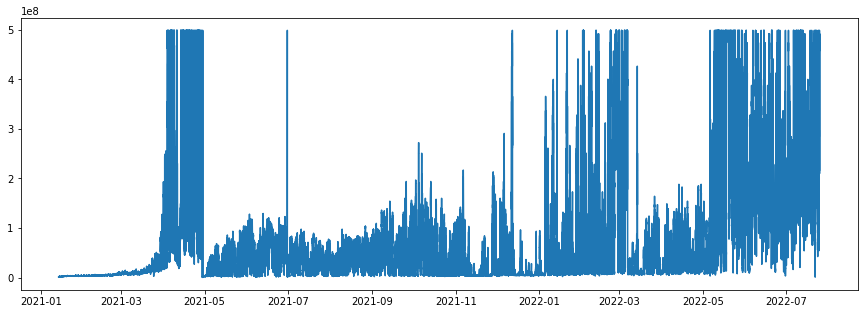

In [458]:
plt.figure(figsize=(15,5))
#plt.plot(norm(appa_clean[(appa_clean.index < "2021-06-30")].ZnOR_1) * max(appa_clean[(appa_clean.index > "2021-06-30")].ZnOR_1))
plt.plot(appa_clean.WO3_2)
plt.show()

In [452]:
appa_clean.loc[(appa_clean.index < "2021-06-30"), "ZnOR_2"] = norm(appa_clean[(appa_clean.index < "2021-06-30")].ZnOR_1) * max(appa_clean[(appa_clean.index > "2021-06-30")].ZnOR_2)

In [41]:
appa1_hr = pd.read_csv("exports/appa_clean.csv")
appa1_gt = pd.read_csv("exports/appa1_gt_clean_withCO.csv")

NameError: name 'pd' is not defined

In [141]:
appa1_clean.columns

Index(['Time', 'ZnOR_1', 'ZnOR_2', 'LaFeO3_1', 'LaFeO3_2', 'WO3_1', 'WO3_2',
       'ZnOR_heatR_1', 'ZnOR_heatR_2', 'LaFeO3_heatR_1', 'LaFeO3_heatR_2',
       'WO3_heatR_1', 'WO3_heatR_2', 'ZnOR_heatV_1', 'ZnOR_heatV_2',
       'LaFeO3_heatV_1', 'LaFeO3_heatV_2', 'WO3_heatV_1', 'WO3_heatV_2',
       'Temperature', 'Relative_Humidity', 'Pressure', 'VOC'],
      dtype='object')

In [142]:
appa1_hr = pd.DataFrame(columns = ['Time', 'ZnOR_1', 'ZnOR_2', 'LaFeO3_1', 'LaFeO3_2', 'WO3_1', 'WO3_2',
       'ZnOR_heatR_1', 'ZnOR_heatR_2', 'LaFeO3_heatR_1', 'LaFeO3_heatR_2',
       'WO3_heatR_1', 'WO3_heatR_2', 'ZnOR_heatV_1', 'ZnOR_heatV_2',
       'LaFeO3_heatV_1', 'LaFeO3_heatV_2', 'WO3_heatV_1', 'WO3_heatV_2',
       'Temperature', 'Relative_Humidity', 'Pressure', 'VOC'])

#for i in tqdm(range(0, len(appa1_clean)-60, 60), total=int(len(appa1_clean)-60)/60):
#       row = appa1_clean.iloc[i:i+60].mean(axis=0)
#       temp = [appa1_clean.iloc[i].Time]
#       temp[1:] = row
#       appa1_hr.loc[len(appa1_hr.index)] = temp


In [159]:
appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
appa1_hr.Time = appa1_hr.Time.dt.tz_localize(None)
appa1_hr = appa1_hr.set_index("Time")

In [161]:
appa1_hr = appa1_hr.resample("H").mean()
#appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
#for i, row in tqdm(appa1_hr.iterrows(), total = len(appa1_hr)):
#    appa1_hr.at[i, "Time"] = row.Time.replace(microsecond=0, second=0, minute=0)

appa1_gt.Time = pd.to_datetime(appa1_gt.Time)


In [162]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,87.505000,...,4.038500,3.981833,3.007167,3.070167,4.022667,4.029667,48.851667,3.573333,988.271667,2961.030333
2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,87.311667,...,4.038000,3.980000,3.002167,3.069833,4.020333,4.028833,44.975000,4.228333,987.405000,3136.489667
2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,87.349153,...,4.037288,3.981186,3.002881,3.070000,4.020508,4.029492,45.900000,3.944068,986.586441,3203.500339
2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,87.360000,...,4.036333,3.981167,3.004000,3.070333,4.021333,4.029833,46.176667,3.858333,985.620000,3250.973833
2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,87.338333,...,4.039000,3.981167,3.002667,3.070000,4.022500,4.029833,46.108333,3.816667,984.713333,3366.150333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,110.933333,...,3.894500,4.022167,3.910833,3.645833,2.390000,2.569833,36.151667,29.928333,989.363333,3469.393333
2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,111.001667,...,3.893000,4.021833,3.910000,3.645667,2.389500,2.569167,36.963333,27.708333,988.421667,4580.721000
2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,111.010000,...,3.894500,4.022500,3.908500,3.645167,2.390000,2.569667,37.466667,26.448333,987.286667,5309.537333


In [163]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,87.505000,...,4.038500,3.981833,3.007167,3.070167,4.022667,4.029667,48.851667,3.573333,988.271667,2961.030333
2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,87.311667,...,4.038000,3.980000,3.002167,3.069833,4.020333,4.028833,44.975000,4.228333,987.405000,3136.489667
2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,87.349153,...,4.037288,3.981186,3.002881,3.070000,4.020508,4.029492,45.900000,3.944068,986.586441,3203.500339
2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,87.360000,...,4.036333,3.981167,3.004000,3.070333,4.021333,4.029833,46.176667,3.858333,985.620000,3250.973833
2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,87.338333,...,4.039000,3.981167,3.002667,3.070000,4.022500,4.029833,46.108333,3.816667,984.713333,3366.150333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,110.933333,...,3.894500,4.022167,3.910833,3.645833,2.390000,2.569833,36.151667,29.928333,989.363333,3469.393333
2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,111.001667,...,3.893000,4.021833,3.910000,3.645667,2.389500,2.569167,36.963333,27.708333,988.421667,4580.721000
2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,111.010000,...,3.894500,4.022500,3.908500,3.645167,2.390000,2.569667,37.466667,26.448333,987.286667,5309.537333


In [164]:
appa1_hr = appa1_hr.merge(appa1_gt, how='left', on="Time")


In [148]:
appa1_gt

,Unnamed: 0,Time,PM10,NO2,SO2,O3,CO
0,72,2020-08-03 04:00:00,9.0,7.0,1.0,82.0,0.688000
1,73,2020-08-03 05:00:00,9.0,12.0,1.0,68.0,0.692000
2,74,2020-08-03 06:00:00,8.0,15.0,1.0,60.0,0.691333
3,75,2020-08-03 07:00:00,8.0,26.0,1.0,47.0,0.734000
4,76,2020-08-03 08:00:00,8.0,21.0,1.0,53.0,0.705333
...,...,...,...,...,...,...,...
17573,17646,2022-07-25 20:00:00,27.0,15.0,3.0,164.0,0.818667
17574,17647,2022-07-25 21:00:00,32.0,11.0,2.0,152.0,0.787333
17575,17648,2022-07-25 22:00:00,28.0,7.0,1.0,112.0,0.779333
17576,17649,2022-07-25 23:00:00,29.0,8.0,1.0,93.0,0.788000


In [165]:
appa1_hr

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,Temperature,Relative_Humidity,Pressure,VOC,Unnamed: 0,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,48.851667,3.573333,988.271667,2961.030333,3936.0,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,44.975000,4.228333,987.405000,3136.489667,3937.0,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,45.900000,3.944068,986.586441,3203.500339,3938.0,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,46.176667,3.858333,985.620000,3250.973833,3939.0,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,46.108333,3.816667,984.713333,3366.150333,3940.0,38.0,74.0,5.0,3.0,1.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14460,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,...,36.151667,29.928333,989.363333,3469.393333,17639.0,20.0,14.0,3.0,141.0,0.811333
14461,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,...,36.963333,27.708333,988.421667,4580.721000,17640.0,18.0,10.0,3.0,165.0,0.810000
14462,2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,...,37.466667,26.448333,987.286667,5309.537333,17641.0,17.0,8.0,3.0,169.0,0.817333
14463,2022-07-25 14:00:00,4.990000e+08,4.990000e+08,1.041554e+07,737042.266667,4.473812e+07,3.280199e+08,128.410000,128.931667,500.000000,...,39.230000,22.996667,986.121667,5605.354833,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
appa1_hr = appa1_hr.drop("Unnamed: 0", axis=1)

In [151]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,Temperature,Relative_Humidity,Pressure,VOC,Time,PM10,NO2,SO2,O3,CO


In [181]:
appa1_hr_cropped

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,4.029667,48.851667,3.573333,988.271667,2961.030333,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,4.028833,44.975000,4.228333,987.405000,3136.489667,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,4.029492,45.900000,3.944068,986.586441,3203.500339,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,4.029833,46.176667,3.858333,985.620000,3250.973833,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,4.029833,46.108333,3.816667,984.713333,3366.150333,38.0,74.0,5.0,3.0,1.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14458,2022-07-25 09:00:00,4.990000e+08,4.990000e+08,2.746416e+06,896828.316667,2.570732e+07,1.694804e+08,128.053333,128.596667,500.000000,...,2.569167,35.240000,32.350000,990.885000,2222.511000,25.0,27.0,4.0,86.0,0.813333
14459,2022-07-25 10:00:00,4.990000e+08,4.990000e+08,3.817816e+06,823806.716667,3.907949e+07,2.790144e+08,128.138333,128.601667,500.000000,...,2.570500,35.500000,31.666667,990.255000,2702.818500,24.0,14.0,3.0,118.0,0.815333
14460,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,...,2.569833,36.151667,29.928333,989.363333,3469.393333,20.0,14.0,3.0,141.0,0.811333
14461,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,...,2.569167,36.963333,27.708333,988.421667,4580.721000,18.0,10.0,3.0,165.0,0.810000


In [171]:
appa1_hr_cropped = appa1_hr.dropna()
appa1_hr_cropped.to_csv("exports/appa1_hr_cropped.csv")

In [168]:
appa1_hr_cropped.NO2.sum()/13701

26.73958105247792

In [154]:
appa1_hr_cropped.iloc[:, 24]

Series([], Name: NO2, dtype: float64)

In [61]:
#Predicting NO2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=42)

In [170]:
rf = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print("Random Forest")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)}")

Random Forest
Median Error: 6.851892424477082 
 Mean error: 8.61948630820265


In [174]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 5.181130439489097 
 Mean error: 6.698107989307862


In [362]:
#Predicting Ozone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=42)

In [253]:
rf = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print("Random Forest")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)}")

Random Forest
Median Error: 13.659506710203928 
 Mean error: 18.147238523991177


In [361]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0, n_estimators=800) #52.78637001398004
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")


Gradient Boosting
Median Error: 10.60601484102903 
 Mean error: 13.844117918646363 
 Mean Squared Error: 333.6746323389416


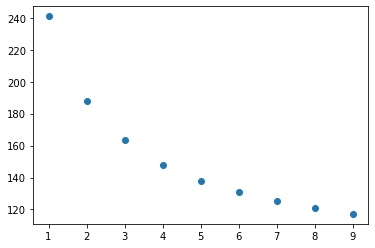

In [375]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=42)
x = []
y = []
for i in range(1,10):
    regr = make_pipeline(StandardScaler(), SVR(C=i/2, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    x.append(i)
    y.append(mean_squared_error(y_test, y_test_pred))
plt.scatter(x,y)
plt.show()

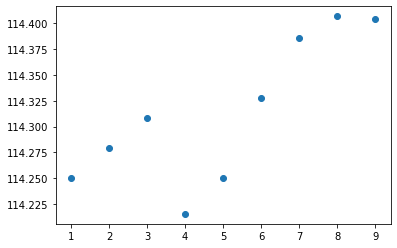

In [376]:
x = []
y = []
for i in range(1,10):
    regr = make_pipeline(StandardScaler(), SVR(C=5, epsilon=i/10))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    x.append(i)
    y.append(mean_squared_error(y_test, y_test_pred))
plt.scatter(x,y)
plt.show()

In [382]:
regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
regr.fit(X_train, y_train)
y_test_pred = regr.predict(X_test)
print("SVR")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

SVR
Median Error: 3.3828569632635492 
 Mean error: 5.677700529648701 
 Mean Squared Error: 78.24446677036455


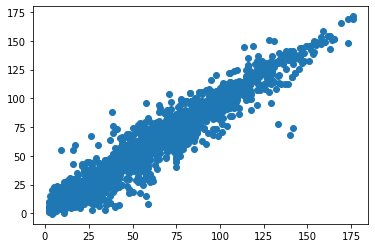

In [383]:
plt.scatter(y_test, y_test_pred)
plt.show()


In [318]:
appa1_sensor = pd.read_csv("appa1_adjusted.csv")

In [319]:
appa1_sensor = appa1_sensor.rename(columns={"ts":"Time"})

In [320]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,year,age
0,2021-01-13 08:00:00,ZnOR,7.513813e+07,67.050000,1.431667,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
1,2021-01-13 08:00:00,ZnOR,7.495123e+07,66.125000,1.475833,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
2,2021-01-13 08:00:00,LaFeO3,7.472385e+07,70.991667,1.843333,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
3,2021-01-13 08:00:00,LaFeO3,2.713244e+07,69.975000,1.802500,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
4,2021-01-13 08:00:00,WO3,4.990000e+08,64.950000,1.730000,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107171,2022-07-25 14:00:00,WO3,2.151412e+08,147.500000,2.565000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,452
107172,2022-07-25 14:00:00,ZnOR,4.990000e+08,128.450000,3.890000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,558
107173,2022-07-25 14:00:00,ZnOR,4.990000e+08,129.150000,4.020000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,558
107174,2022-07-25 14:00:00,SmFeO3,3.208780e+07,103.800000,3.950000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,192


In [321]:
#2021-01-14 00:00:00
appa1_sensor = appa1_sensor.iloc[128:]

In [322]:
appa1_sensor = appa1_sensor.iloc[:107040]

In [323]:
appa1_sensor = appa1_sensor.drop("year", axis=1)

In [324]:
no2 = []
co = []
o3 = []
index = 0
time = appa1_sensor.iloc[0].Time
for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if time == str(row.Time):
        no2.append(appa1_hr_cropped.iloc[index].NO2)
        co.append(appa1_hr_cropped.iloc[index].CO)
        o3.append(appa1_hr_cropped.iloc[index].O3)
    else:
        index+=1
        time = row.Time
        no2.append(appa1_hr_cropped.iloc[index].NO2)
        co.append(appa1_hr_cropped.iloc[index].CO)
        o3.append(appa1_hr_cropped.iloc[index].O3)


100%|██████████| 107040/107040 [00:36<00:00, 2960.66it/s]


In [325]:
appa1_sensor["NO2"] = no2
appa1_sensor["CO"] = co
appa1_sensor["O3"] = o3

In [326]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,age,NO2,CO,O3
128,2021-01-14 00:00:00,ZnOR,2.227298e+05,102.151667,4.038500,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
129,2021-01-14 00:00:00,ZnOR,1.239792e+05,99.416667,3.981833,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
130,2021-01-14 00:00:00,LaFeO3,6.439906e+05,88.176667,3.007167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
131,2021-01-14 00:00:00,LaFeO3,5.119072e+05,87.505000,3.070167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
132,2021-01-14 00:00:00,WO3,8.852432e+05,39.276667,4.022667,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107163,2022-07-25 13:00:00,WO3,3.280199e+08,147.463333,2.570000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,452,9.0,0.737333,85.0
107164,2022-07-25 13:00:00,ZnOR,4.990000e+08,128.410000,3.895000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107165,2022-07-25 13:00:00,ZnOR,4.990000e+08,128.931667,4.024000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107166,2022-07-25 13:00:00,SmFeO3,2.723392e+07,103.621667,3.950000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,192,9.0,0.737333,85.0


In [327]:
for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if row.sensing_material == "ZnO":
        appa1_sensor.at[i, "sensing_material"] = 1
    elif row.sensing_material == "LaFeO3":
        appa1_sensor.at[i, "sensing_material"] = 2
    elif row.sensing_material == "WO3":
        appa1_sensor.at[i, "sensing_material"] = 3
    elif row.sensing_material == "ZnOR":
        appa1_sensor.at[i, "sensing_material"] = 4
    elif row.sensing_material == "ZnOg":
        appa1_sensor.at[i, "sensing_material"] = 5
    elif row.sensing_material == "SmFe03":
        appa1_sensor.at[i, "sensing_material"] = 6
    else:
        appa1_sensor.at[i, "sensing_material"] = 7

100%|██████████| 107040/107040 [00:06<00:00, 17183.18it/s]


In [329]:
#Predicting NO2 with sensors as features
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(appa1_sensor.iloc[:, 1:15], appa1_sensor.iloc[:, 17] , test_size=0.2, random_state=42)

In [331]:
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 13.473079683495286 
 Mean error: 16.96630783384489 
 Mean Squared Error: 472.1120453730076


In [338]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,age,NO2,CO,O3
128,2021-01-14 00:00:00,4,2.227298e+05,102.151667,4.038500,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
129,2021-01-14 00:00:00,4,1.239792e+05,99.416667,3.981833,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
130,2021-01-14 00:00:00,2,6.439906e+05,88.176667,3.007167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
131,2021-01-14 00:00:00,2,5.119072e+05,87.505000,3.070167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
132,2021-01-14 00:00:00,3,8.852432e+05,39.276667,4.022667,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107163,2022-07-25 13:00:00,3,3.280199e+08,147.463333,2.570000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,452,9.0,0.737333,85.0
107164,2022-07-25 13:00:00,4,4.990000e+08,128.410000,3.895000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107165,2022-07-25 13:00:00,4,4.990000e+08,128.931667,4.024000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107166,2022-07-25 13:00:00,7,2.723392e+07,103.621667,3.950000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,192,9.0,0.737333,85.0


In [348]:
appa1_sensor_LaFeO3 = pd.DataFrame()
appa1_sensor_WO3 = pd.DataFrame()
appa1_sensor_ZnOR = pd.DataFrame()

for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if row.sensing_material == 2:
        appa1_sensor_LaFeO3 = appa1_sensor_LaFeO3.append(row)
    elif row.sensing_material == 3:
        appa1_sensor_WO3 = appa1_sensor_WO3.append(row)
    elif row.sensing_material == 4:
        appa1_sensor_ZnOR = appa1_sensor_ZnOR.append(row)


100%|██████████| 107040/107040 [03:38<00:00, 489.97it/s]


In [360]:
#LaFe03 Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_LaFeO3.iloc[:, 1:15], appa1_sensor_LaFeO3.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

IndexError: single positional indexer is out-of-bounds

In [358]:
#WO3 Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_WO3.iloc[:, 1:15], appa1_sensor_WO3.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 12.563385403826528 
 Mean error: 16.009485807104177 
 Mean Squared Error: 426.5869003602038


In [359]:
#ZnOR Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_ZnOR.iloc[:, 1:15], appa1_sensor_ZnOR.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 12.284831980893447 
 Mean error: 15.65906107846902 
 Mean Squared Error: 415.6121273396209


In [7]:
!pip3 install torch torchvision torchaudio

     |████████████████████████████████| 133.6 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 3.1 MB/s eta 0:00:01


,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,4.029667,48.851667,3.573333,988.271667,2961.030333,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,4.028833,44.975000,4.228333,987.405000,3136.489667,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,4.029492,45.900000,3.944068,986.586441,3203.500339,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,4.029833,46.176667,3.858333,985.620000,3250.973833,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,4.029833,46.108333,3.816667,984.713333,3366.150333,38.0,74.0,5.0,3.0,1.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13696,2022-07-25 09:00:00,4.990000e+08,4.990000e+08,2.746416e+06,896828.316667,2.570732e+07,1.694804e+08,128.053333,128.596667,500.000000,...,2.569167,35.240000,32.350000,990.885000,2222.511000,25.0,27.0,4.0,86.0,0.813333
13697,2022-07-25 10:00:00,4.990000e+08,4.990000e+08,3.817816e+06,823806.716667,3.907949e+07,2.790144e+08,128.138333,128.601667,500.000000,...,2.570500,35.500000,31.666667,990.255000,2702.818500,24.0,14.0,3.0,118.0,0.815333
13698,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,...,2.569833,36.151667,29.928333,989.363333,3469.393333,20.0,14.0,3.0,141.0,0.811333
13699,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,...,2.569167,36.963333,27.708333,988.421667,4580.721000,18.0,10.0,3.0,165.0,0.810000


In [281]:
#Predicting O3

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=42)
appa1_hr_cropped

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals = evaluate_model(test_dl, net)



epoch 0 done, loss 0.01585075818002224
epoch 1 done, loss 0.001268188119865954
epoch 2 done, loss 0.11551852524280548
epoch 3 done, loss 0.007649112958461046
epoch 4 done, loss 0.021565629169344902
epoch 5 done, loss 0.008964496664702892
epoch 6 done, loss 0.0036554657854139805
epoch 7 done, loss 0.0053605856373906136
epoch 8 done, loss 0.0016135869082063437
epoch 9 done, loss 0.05090837925672531
epoch 10 done, loss 8.74214165378362e-05
epoch 11 done, loss 0.21396318078041077
epoch 12 done, loss 4.25154939875938e-05
epoch 13 done, loss 0.05607054755091667
epoch 14 done, loss 0.01365682389587164
epoch 15 done, loss 0.0160275399684906
epoch 16 done, loss 0.010918044485151768
epoch 17 done, loss 0.0005247861263342202
epoch 18 done, loss 0.032960932701826096
epoch 19 done, loss 0.043079718947410583
epoch 20 done, loss 0.017169257625937462
epoch 21 done, loss 0.0027610845863819122
epoch 22 done, loss 0.008187930099666119
epoch 23 done, loss 0.07960151135921478
epoch 24 done, loss 0.00049904

In [286]:
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")


Mean Squared Error: 60.35356052376406
Median absolute error: 3.4358673095703125
Mean Absolute Error: 5.270982255060355


In [291]:
#Predicting NO2

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=42)
appa1_hr_cropped

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals = evaluate_model(test_dl, net)



epoch 0 done, loss 0.7143466472625732
epoch 1 done, loss 0.2808215022087097
epoch 2 done, loss 0.019222483038902283
epoch 3 done, loss 0.07673587650060654
epoch 4 done, loss 0.022577771916985512
epoch 5 done, loss 0.0016680200351402164
epoch 6 done, loss 0.3289312720298767
epoch 7 done, loss 0.09923616796731949
epoch 8 done, loss 1.0475536584854126
epoch 9 done, loss 0.10342661291360855
epoch 10 done, loss 0.06186424195766449
epoch 11 done, loss 0.042870402336120605
epoch 12 done, loss 0.027138961479067802
epoch 13 done, loss 0.1362508088350296
epoch 14 done, loss 0.016962742432951927
epoch 15 done, loss 1.730880618095398
epoch 16 done, loss 0.604675829410553
epoch 17 done, loss 0.0026995062362402678
epoch 18 done, loss 0.3667951226234436
epoch 19 done, loss 0.1364545226097107
epoch 20 done, loss 0.21572567522525787
epoch 21 done, loss 0.019845424219965935
epoch 22 done, loss 0.07367755472660065
epoch 23 done, loss 0.3436052203178406
epoch 24 done, loss 0.3918123245239258
epoch 25 done

In [292]:
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals[1]),  scalerY_train.inverse_transform(evals[0]))}")

Mean Squared Error: 84.41029454988566
Median absolute error: 4.761333465576172
Mean Absolute Error: 6.621006682074796


<AxesSubplot:xlabel='Time'>

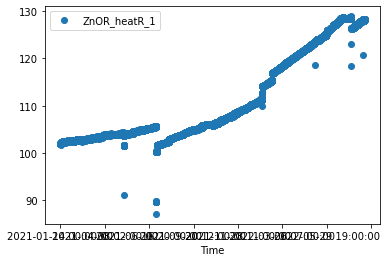

In [365]:
appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_outlier = appa1_outlier.drop("Unnamed: 0", axis=1)
appa1_outlier.plot(x='Time', y='ZnOR_heatR_1', style='o')

In [372]:

index = []
for i, row in appa1_outlier.iloc[:-2].iterrows():
    #print((row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1))
    if (row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1) > 1.03 or (row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1) < 0.97:
        index.append(i)
print(index)
appa1_outlier = appa1_outlier.drop(index)
appa1_outlier = appa1_outlier.reset_index(drop = True)


[4302, 4313]


[4307, 4317, 9086]


In [374]:
appa1_outlier = appa1_outlier.drop(4303)


<AxesSubplot:xlabel='Time'>

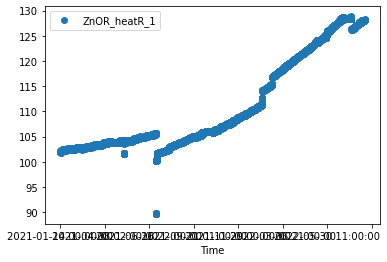

In [375]:
appa1_outlier.plot(x='Time', y='ZnOR_heatR_1', style='o')

In [415]:
appa1_outlier.columns[24]

'NO2'

In [386]:
#Predicting NO2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_outlier.iloc[:, 1:23], appa1_outlier.iloc[:, 24] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_NO2 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[24]}:")
print(f"Range of O3: {appa1_outlier.NO2.max()-appa1_outlier.NO2.min()}")
print(f"Mean of O3: {appa1_outlier.NO2.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]))}")

epoch 0 done, loss 0.6746580600738525
epoch 1 done, loss 0.008086804300546646
epoch 2 done, loss 0.05368746072053909
epoch 3 done, loss 0.3077036142349243
epoch 4 done, loss 0.0422692634165287
epoch 5 done, loss 0.5397845506668091
epoch 6 done, loss 0.0050710951909422874
epoch 7 done, loss 0.17160016298294067
epoch 8 done, loss 0.3909554183483124
epoch 9 done, loss 0.0027226333040744066
epoch 10 done, loss 0.16274169087409973
epoch 11 done, loss 0.11183629184961319
epoch 12 done, loss 0.01830482669174671
epoch 13 done, loss 0.33612021803855896
epoch 14 done, loss 0.19879424571990967
epoch 15 done, loss 1.391037940979004
epoch 16 done, loss 0.105948805809021
epoch 17 done, loss 0.22263740003108978
epoch 18 done, loss 0.04654205963015556
epoch 19 done, loss 0.007149432320147753
epoch 20 done, loss 0.01593480259180069
epoch 21 done, loss 0.043992236256599426
epoch 22 done, loss 0.05541131645441055
epoch 23 done, loss 0.1821691393852234
epoch 24 done, loss 0.00010202820703852922
epoch 25 d

In [392]:
#Predicting SO2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_outlier.iloc[:, 1:23], appa1_outlier.iloc[:, 25] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_SO2 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[25]}:")
print(f"Range of O3: {appa1_outlier.SO2.max()-appa1_outlier.SO2.min()}")
print(f"Mean of O3: {appa1_outlier.SO2.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]))}")


epoch 0 done, loss 0.03448998183012009
epoch 1 done, loss 0.04966016858816147
epoch 2 done, loss 0.5739729404449463
epoch 3 done, loss 1.6585254669189453
epoch 4 done, loss 0.3041258454322815
epoch 5 done, loss 0.05907471105456352
epoch 6 done, loss 0.8586041927337646
epoch 7 done, loss 0.01154305785894394
epoch 8 done, loss 0.04227825626730919
epoch 9 done, loss 1.1415349245071411
epoch 10 done, loss 0.08772598952054977
epoch 11 done, loss 0.17617671191692352
epoch 12 done, loss 0.15901228785514832
epoch 13 done, loss 0.0029237770941108465
epoch 14 done, loss 0.1611524224281311
epoch 15 done, loss 0.025158319622278214
epoch 16 done, loss 0.800988495349884
epoch 17 done, loss 7.026929233688861e-05
epoch 18 done, loss 2.2445123195648193
epoch 19 done, loss 1.071468472480774
epoch 20 done, loss 0.03584396839141846
epoch 21 done, loss 0.4913243353366852
epoch 22 done, loss 0.1169533059000969
epoch 23 done, loss 2.0990824699401855
epoch 24 done, loss 0.3381313681602478
epoch 25 done, loss 

In [398]:
#Predicting O3

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_outlier.iloc[:, 1:23], appa1_outlier.iloc[:, 26] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_O3 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[26]}:")
print(f"Range of O3: {appa1_outlier.O3.max()-appa1_outlier.O3.min()}")
print(f"Mean of O3: {appa1_outlier.O3.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]))}")

epoch 0 done, loss 0.21158486604690552
epoch 1 done, loss 0.11331019550561905
epoch 2 done, loss 0.2579461932182312
epoch 3 done, loss 0.12592388689517975
epoch 4 done, loss 0.00374353164806962
epoch 5 done, loss 0.011756963096559048
epoch 6 done, loss 0.0016273113433271646
epoch 7 done, loss 0.010645021684467793
epoch 8 done, loss 0.5102201104164124
epoch 9 done, loss 0.0009337725350633264
epoch 10 done, loss 0.14860761165618896
epoch 11 done, loss 0.0018860652344301343
epoch 12 done, loss 0.04121752828359604
epoch 13 done, loss 0.017477218061685562
epoch 14 done, loss 0.11390170454978943
epoch 15 done, loss 0.006610895041376352
epoch 16 done, loss 0.00029863076633773744
epoch 17 done, loss 0.006298370193690062
epoch 18 done, loss 0.04022970795631409
epoch 19 done, loss 0.004122502636164427
epoch 20 done, loss 2.9403212465695105e-05
epoch 21 done, loss 0.029737668111920357
epoch 22 done, loss 0.003120224457234144
epoch 23 done, loss 0.018085816875100136
epoch 24 done, loss 0.001332162

In [419]:
appa2

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,STN_heatV_1,STN_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,LaFeO3_1_TimeSinceCreated,LaFeO3_2_TimeSinceCreated,STN_1_TimeSinceCreated,STN_2_TimeSinceCreated
0,2021-01-13 10:00:00+00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,2.745652,2.722826,30.823913,16.413043,994.056522,1381.336739,36000,36000,36000,36000
1,2021-01-13 11:00:00+00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,4.389153,4.351695,39.594915,9.179661,992.691525,1868.565932,39600,39600,39600,39600
2,2021-01-13 12:00:00+00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,4.390169,4.352373,39.227119,9.366102,991.983051,1887.251356,43200,43200,43200,43200
3,2021-01-13 13:00:00+00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,4.388814,4.352034,39.427119,9.438983,991.622034,1863.711017,46800,46800,46800,46800
4,2021-01-13 14:00:00+00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,4.388814,4.351186,38.484746,9.711864,991.632203,1845.569322,50400,50400,50400,50400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12425,2022-07-25 11:00:00+00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,4.270000,4.078136,39.523729,26.657627,990.896610,5557.048644,39092400,39092400,39092400,33735600
12426,2022-07-25 12:00:00+00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,4.270000,4.078305,40.447458,24.930508,989.783051,6800.150678,39096000,39096000,39096000,33739200
12427,2022-07-25 13:00:00+00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,4.268305,4.077627,40.357627,24.781356,988.783051,7490.784237,39099600,39099600,39099600,33742800
12428,2022-07-25 14:00:00+00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,4.268644,4.075424,40.801695,23.944068,987.733898,7699.991186,39103200,39103200,39103200,33746400


In [438]:
appa2 = pd.read_csv("exports/appa_hr_2_crop_withCreated.csv")
appa2_gt = pd.read_csv("appa2_gt.csv")
appa2.Time = pd.to_datetime(appa2.Time)
appa2_gt.Time = pd.to_datetime(appa2_gt.Time)
appa2.Time = appa2.Time.dt.tz_localize(None)
appa2 = appa2.merge(appa2_gt, how='left', on="Time")


In [439]:
appa2

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,Relative_Humidity,Pressure,VOC,LaFeO3_1_TimeSinceCreated,LaFeO3_2_TimeSinceCreated,STN_1_TimeSinceCreated,STN_2_TimeSinceCreated,PM10,Ossido di Carbonio,Biossido di Azoto
0,2021-01-13 10:00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,16.413043,994.056522,1381.336739,36000,36000,36000,36000,53.0,0.9,76.0
1,2021-01-13 11:00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,9.179661,992.691525,1868.565932,39600,39600,39600,39600,53.0,0.8,67.0
2,2021-01-13 12:00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,9.366102,991.983051,1887.251356,43200,43200,43200,43200,48.0,0.7,68.0
3,2021-01-13 13:00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,9.438983,991.622034,1863.711017,46800,46800,46800,46800,43.0,0.7,71.0
4,2021-01-13 14:00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,9.711864,991.632203,1845.569322,50400,50400,50400,50400,46.0,0.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,2022-07-25 11:00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,26.657627,990.896610,5557.048644,39092400,39092400,39092400,33735600,24.0,0.9,19.0
12615,2022-07-25 12:00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,24.930508,989.783051,6800.150678,39096000,39096000,39096000,33739200,21.0,0.9,32.0
12616,2022-07-25 13:00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,24.781356,988.783051,7490.784237,39099600,39099600,39099600,33742800,20.0,0.9,33.0
12617,2022-07-25 14:00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,23.944068,987.733898,7699.991186,39103200,39103200,39103200,33746400,19.0,0.9,20.0


In [445]:
appa2 = appa2.dropna()
appa2 = appa2.rename(columns={"Ossido di Carbonio":"CO"})

In [467]:
#Predicting CO from APPA2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa2.iloc[:, 1:19], appa2.iloc[:, 22] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(18, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_CO_2 = evaluate_model(test_dl, net)

print(f"{appa2.columns[22]}:")
print(f"Range of CO: {appa2.CO.max()-appa2.CO.min()}")
print(f"Mean of CO: {appa2.CO.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")

epoch 0 done, loss 0.16935665905475616
epoch 1 done, loss 0.000157478847540915
epoch 2 done, loss 0.015889396890997887
epoch 3 done, loss 0.7129274010658264
epoch 4 done, loss 0.32052576541900635
epoch 5 done, loss 0.010584674775600433
epoch 6 done, loss 0.04678903520107269
epoch 7 done, loss 0.02022039331495762
epoch 8 done, loss 0.004029349889606237
epoch 9 done, loss 0.057541653513908386
epoch 10 done, loss 0.08385542780160904
epoch 11 done, loss 0.18111206591129303
epoch 12 done, loss 0.0012358822859823704
epoch 13 done, loss 0.019594622775912285
epoch 14 done, loss 0.011977807618677616
epoch 15 done, loss 0.00996311940252781
epoch 16 done, loss 0.015524609014391899
epoch 17 done, loss 0.0014919413952156901
epoch 18 done, loss 0.004074506927281618
epoch 19 done, loss 0.027677243575453758
epoch 20 done, loss 0.001955675892531872
epoch 21 done, loss 0.02263435162603855
epoch 22 done, loss 0.03609166294336319
epoch 23 done, loss 0.07846879214048386
epoch 24 done, loss 0.03080270998179

In [459]:
weather

,Time,ronc uv,ronc rain,ronc w_sp,ronc w_dir,laste uv,laste rain,laste w_sp,laste w_dir
0,2012-01-01 01:00:00,0.0,0.0,0.650000,211.416667,0.0,0.0,0.825000,100.750000
1,2012-01-01 02:00:00,0.0,0.0,0.633333,149.083333,0.0,0.0,0.675000,178.250000
2,2012-01-01 03:00:00,0.0,0.0,0.625000,221.083333,0.0,0.0,1.250000,168.750000
3,2012-01-01 04:00:00,0.0,0.0,0.600000,188.000000,0.0,0.0,0.925000,183.500000
4,2012-01-01 05:00:00,0.0,0.0,0.700000,194.500000,0.0,0.0,1.500000,261.250000
...,...,...,...,...,...,...,...,...,...
92707,2022-07-29 20:00:00,0.0,2.4,1.700000,318.666667,0.0,2.4,1.150000,270.500000
92708,2022-07-29 21:00:00,0.0,0.2,1.683333,226.166667,0.0,0.8,1.500000,276.666667
92709,2022-07-29 22:00:00,0.0,1.4,2.050000,318.000000,0.0,0.6,1.583333,311.666667
92710,2022-07-29 23:00:00,0.0,0.4,1.750000,330.000000,0.0,0.2,1.383333,321.000000


In [468]:
weather["ronc uv"].mean()

561.4958710846464

In [493]:
appa2_weather = pd.read_csv("exports/appa_hr_2_crop_withCreated.csv")
appa2_gt = pd.read_csv("appa2_gt.csv")
weather = pd.read_csv("exports/weather_data.csv")
weather = weather.rename(columns={"date":"Time"})
weather.Time = pd.to_datetime(weather.Time)
appa2_weather.Time = pd.to_datetime(appa2_weather.Time)
appa2_gt.Time = pd.to_datetime(appa2_gt.Time)
appa2_weather.Time = appa2_weather.Time.dt.tz_localize(None)
appa2_weather = appa2_weather.merge(weather, how='left', on="Time")
appa2_weather = appa2_weather.merge(appa2_gt, how='left', on="Time")
appa2_weather = appa2_weather.drop(columns=["ronc uv","laste uv"], axis=1)
appa2_weather = appa2_weather.rename(columns={"Ossido di Carbonio":"CO"})
appa2_weather = appa2_weather.dropna()

In [486]:
appa2_weather

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,STN_2_TimeSinceCreated,ronc rain,ronc w_sp,ronc w_dir,laste rain,laste w_sp,laste w_dir,PM10,Ossido di Carbonio,Biossido di Azoto
0,2021-01-13 10:00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,36000,0.0,1.000000,239.000000,0.0,1.066667,274.000000,53.0,0.9,76.0
1,2021-01-13 11:00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,39600,0.0,1.483333,335.500000,0.0,2.066667,271.166667,53.0,0.8,67.0
2,2021-01-13 12:00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,43200,0.0,1.766667,344.666667,0.0,2.050000,320.166667,48.0,0.7,68.0
3,2021-01-13 13:00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,46800,0.0,2.216667,241.166667,0.0,1.350000,301.666667,43.0,0.7,71.0
4,2021-01-13 14:00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,50400,0.0,0.966667,242.000000,0.0,0.933333,180.166667,46.0,0.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,2022-07-25 11:00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,33735600,0.0,1.566667,188.833333,0.0,1.900000,181.500000,24.0,0.9,19.0
12615,2022-07-25 12:00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,33739200,0.0,2.783333,136.833333,0.0,1.866667,217.833333,21.0,0.9,32.0
12616,2022-07-25 13:00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,33742800,0.0,3.133333,205.666667,0.0,2.450000,278.666667,20.0,0.9,33.0
12617,2022-07-25 14:00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,33746400,0.0,4.566667,108.833333,0.0,2.200000,210.333333,19.0,0.9,20.0


In [479]:
min(X_train, key=lambda x: x[1])

array([-0.32940229, -0.71867922,  0.77566753,  0.33340025, -0.00621576,
        0.47266142, -0.26979931, -0.18615748, -0.25643003, -1.60907611,
       -0.50981155, -0.5913345 ,  0.63155215, -1.82532944,  0.50481041,
        1.98993364,  0.82786015,  0.82786015,  0.82786015,  0.73009437,
       -0.13503861,  3.05310982, -1.6609483 , -0.12666417,  1.70490798,
       -0.65808451])

In [494]:
appa2_weather

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,STN_2_TimeSinceCreated,ronc rain,ronc w_sp,ronc w_dir,laste rain,laste w_sp,laste w_dir,PM10,CO,Biossido di Azoto
0,2021-01-13 10:00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,36000,0.0,1.000000,239.000000,0.0,1.066667,274.000000,53.0,0.9,76.0
1,2021-01-13 11:00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,39600,0.0,1.483333,335.500000,0.0,2.066667,271.166667,53.0,0.8,67.0
2,2021-01-13 12:00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,43200,0.0,1.766667,344.666667,0.0,2.050000,320.166667,48.0,0.7,68.0
3,2021-01-13 13:00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,46800,0.0,2.216667,241.166667,0.0,1.350000,301.666667,43.0,0.7,71.0
4,2021-01-13 14:00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,50400,0.0,0.966667,242.000000,0.0,0.933333,180.166667,46.0,0.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,2022-07-25 11:00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,33735600,0.0,1.566667,188.833333,0.0,1.900000,181.500000,24.0,0.9,19.0
12615,2022-07-25 12:00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,33739200,0.0,2.783333,136.833333,0.0,1.866667,217.833333,21.0,0.9,32.0
12616,2022-07-25 13:00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,33742800,0.0,3.133333,205.666667,0.0,2.450000,278.666667,20.0,0.9,33.0
12617,2022-07-25 14:00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,33746400,0.0,4.566667,108.833333,0.0,2.200000,210.333333,19.0,0.9,20.0


In [495]:
#Predicting CO from APPA2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa2_weather.iloc[:, 1:27], appa2_weather.iloc[:, 28] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(26, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_CO_2 = evaluate_model(test_dl, net)

print(f"{appa2_weather.columns[28]}:")
print(f"Range of CO: {appa2_weather.CO.max()-appa2_weather.CO.min()}")
print(f"Mean of CO: {appa2_weather.CO.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")

epoch 0 done, loss 0.0667615458369255
epoch 1 done, loss 0.01059104222804308
epoch 2 done, loss 0.031533826142549515
epoch 3 done, loss 0.04605662450194359
epoch 4 done, loss 0.016447391360998154
epoch 5 done, loss 0.02928282506763935
epoch 6 done, loss 0.002171852858737111
epoch 7 done, loss 4.0045647621154785
epoch 8 done, loss 0.007982649840414524
epoch 9 done, loss 0.18865931034088135
epoch 10 done, loss 0.00795434694737196
epoch 11 done, loss 0.00031056409352459013
epoch 12 done, loss 0.0005587977939285338
epoch 13 done, loss 0.021568557247519493
epoch 14 done, loss 0.008972500450909138
epoch 15 done, loss 0.0321146659553051
epoch 16 done, loss 0.008217263966798782
epoch 17 done, loss 0.0003718690131790936
epoch 18 done, loss 0.024072112515568733
epoch 19 done, loss 0.0002473267668392509
epoch 20 done, loss 0.0699697807431221
epoch 21 done, loss 0.2032884657382965
epoch 22 done, loss 0.08767786622047424
epoch 23 done, loss 0.00764942541718483
epoch 24 done, loss 0.0284983888268470

In [499]:
torch.save(net, "NN_CO_APPA2.pkl")

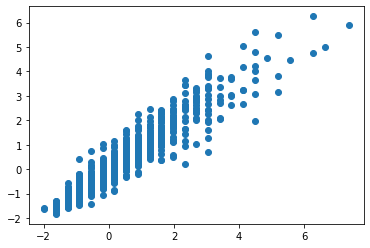

In [496]:
plt.scatter(evals_CO_2[0], evals_CO_2[1])